In [1]:
from dataset_loader import load_dataset
from utils import *

import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from metric_learn import ITML, SDML
import seaborn as sns

import os

In [28]:
def generate_semantic_pairs(dataset, num_pairs, num_closest):
    random_pairs = []
    y = []
    
    for _ in range(num_pairs):
        # Choose one random index for the first element of the pair
        idx1 = random.choice(range(len(dataset)))
        
        # Calculate distances from dataset[idx1] to all other vectors
        distances = vectorized_cosine_distances_normalized(dataset[idx1], dataset)

        # Get the indices of the closest num_closest vectors (excluding idx1)
        closest_indices = np.argsort(distances)[:num_closest + 1]  # +1 to include idx1 itself
        closest_indices = [idx for idx in closest_indices if idx != idx1]  # Exclude idx1
        
        # Ensure there are enough closest indices
        if len(closest_indices) < 1:
            raise ValueError("Not enough distinct vectors in the dataset to form pairs.")
        
        # Choose one index for the similar 
        idx2 = random.choice(closest_indices[:15])
        
        # Choose one index for the dissimilar
        idx3 = random.choice(closest_indices[15:30])
        
        pair1 = [dataset[idx1], dataset[idx2]]
        pair2 = [dataset[idx1], dataset[idx3]]
        
        random_pairs.append(pair1)
        random_pairs.append(pair2)
        
        y.append(1)   # Positive pair
        y.append(-1)  # Negative pair
        
    return random_pairs, y

In [32]:
def run_itml_experiment(prior_matrix, pairs, labels):
    # Train ITML model
    itml_model = ITML(gamma=1, max_iter=1000, prior=prior_matrix)
    itml_model.fit(pairs, labels)

    # Get Mahalanobis matrix and calculate results
    mahalanobis_matrix = itml_model.get_mahalanobis_matrix()
    scaling_factor = calculate_scaling_factor(mahalanobis_matrix).real
    # print("ITML SF: ", scaling_factor)

    # Store the results in a dictionary
    result = {
        'Num of Inputs': len(pairs) / 2,  # Count each experiment as one input
        'Scaling Factor': format(scaling_factor, '.6f')
    }

    return result, mahalanobis_matrix


def run_sdml_experiment(prior_matrix, pairs, labels):
    # Train SDML model
    model = SDML(balance_param=0.5, sparsity_param=0.01, prior=prior_matrix)
    model.fit(pairs, labels)

    # Get Mahalanobis matrix and calculate results
    mahalanobis_matrix = model.get_mahalanobis_matrix()
    scaling_factor = calculate_scaling_factor(mahalanobis_matrix).real
    # print(f"SDML SF {scaling_factor}")

    # Store the results in a dictionary
    result = {
        'Num of Inputs': len(pairs) / 2,  # Count each experiment as one input
        'Scaling Factor': format(scaling_factor, '.6f')
    }

    return result, mahalanobis_matrix

In [4]:
# Specify the directory you want to read from
directory = os.path.join(os.path.dirname(os.getcwd()), 'ViT-L14')

# size = 252001
files_set_4 = [
    '003.txt', '004.txt', '005.txt', 
    '006.txt', '007.txt', '048.txt',
    '049.txt', '055.txt', '056.txt',
    '057.txt'
]

In [5]:
image_names, dataset = load_dataset(directory, files_set_4)

Processing file: 003.txt
	Number of vectors: 5516
Processing file: 004.txt
	Number of vectors: 8386
Processing file: 005.txt
	Number of vectors: 13638
Processing file: 006.txt
	Number of vectors: 17044
Processing file: 007.txt
	Number of vectors: 15181
Processing file: 048.txt
	Number of vectors: 26687
Processing file: 049.txt
	Number of vectors: 44032
Processing file: 055.txt
	Number of vectors: 43070
Processing file: 056.txt
	Number of vectors: 39764
Processing file: 057.txt
	Number of vectors: 38683

Number of vectors in all files: 252001
Number of dimensions: 768


In [6]:
dataset = np.array(dataset)

In [40]:
results = pd.DataFrame(columns=['Num of Inputs', 'Scaling Factor', 'Experiment Type'])

In [41]:
# Initialize a list to store all results
all_results = []
initial_subset_size = 40
current_prior_matrix = np.eye(len(dataset[0]))

for experiment in range(5):
    generated_pairs_nearest, labels_nearest = generate_semantic_pairs(dataset, 200, 50)
    # print("Generation finished")
    itml_M = np.eye(len(dataset[0]))
    sdml_M = np.eye(len(dataset[0]))
    total_num_inputs = 0
    
    for i in range(1, 6):
        start_index = (i - 1) * initial_subset_size * 2
        end_index = i * initial_subset_size * 2
    
        # Take a subset of the generated pairs and labels based on the calculated range
        pairs_subset = generated_pairs_nearest[start_index:end_index]
        labels_subset = labels_nearest[start_index:end_index]
        
        total_num_inputs += initial_subset_size

        # Run the ITML experiment
        itml_result, itml_M = run_itml_experiment(itml_M, pairs_subset, labels_subset)
        itml_result['Experiment Type'] = 'ITML batch 40 (Semantic Inputs)'
        itml_result['Num of Inputs'] = total_num_inputs

        # Store ITML results
        all_results.append(itml_result)

        # Run the SDML experiment
        sdml_result, sdml_M = run_sdml_experiment(sdml_M, pairs_subset, labels_subset)
        sdml_result['Experiment Type'] = 'SDML batch 40 (Semantic Inputs)'
        sdml_result['Num of Inputs'] = total_num_inputs

        # Store SDML results
        all_results.append(sdml_result)

# Convert results to a DataFrame
results = pd.concat([results, pd.DataFrame(all_results)], ignore_index=True)

In [43]:
results.to_pickle('exp_4_batch_learning.pkl')

In [44]:
results = pd.read_pickle('exp_4_batch_learning.pkl')

In [45]:
results

,Num of Inputs,Scaling Factor,Experiment Type
0,40,1.001612,ITML batch 40 (Semantic Inputs)
1,40,1.007480,SDML batch 40 (Semantic Inputs)
2,80,1.001586,ITML batch 40 (Semantic Inputs)
3,80,1.006482,SDML batch 40 (Semantic Inputs)
4,120,1.030331,ITML batch 40 (Semantic Inputs)
5,120,1.010162,SDML batch 40 (Semantic Inputs)
6,160,1.037743,ITML batch 40 (Semantic Inputs)
7,160,1.006323,SDML batch 40 (Semantic Inputs)
8,200,1.040367,ITML batch 40 (Semantic Inputs)
9,200,1.007386,SDML batch 40 (Semantic Inputs)


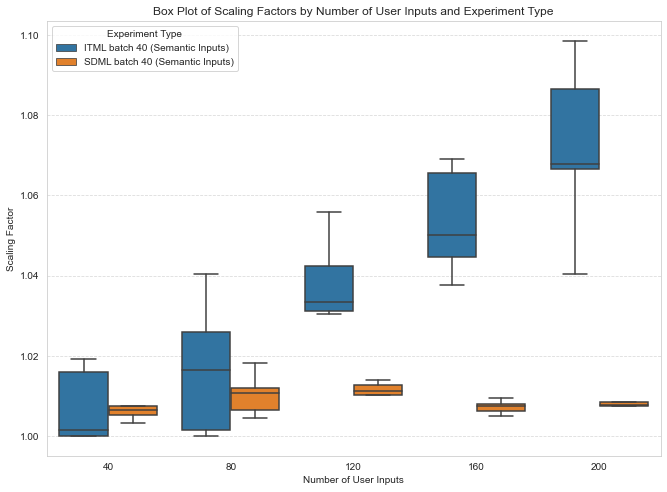

In [46]:
# Convert 'Num Pairs' to a categorical variable for better grouping in Seaborn
results['Num of Inputs'] = results['Num of Inputs'].astype(int)
results['Scaling Factor'] = pd.to_numeric(results['Scaling Factor'])

# Plotting with Seaborn
plt.figure(figsize=(11, 8))
sns.boxplot(
    data=results,
    x='Num of Inputs',
    y='Scaling Factor',
    hue='Experiment Type',  # Subgroups
    showfliers=False  # Hide outliers for clearer visualization
)

# Add labels and title
plt.xlabel('Number of User Inputs')
plt.ylabel('Scaling Factor')
plt.title('Box Plot of Scaling Factors by Number of User Inputs and Experiment Type')
plt.legend(title='Experiment Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()